In [1]:
import time
from typing import Optional, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

# Mobilenet v1: [https://arxiv.org/abs/1704.04861](https://arxiv.org/abs/1704.04861)

compare depthwise separable convolutions 3x3, 5x5 and 7x7

In [7]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [8]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [9]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=1024,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [10]:
class MyMobileNetV1(nn.Module):
    def __init__(self, channels: int, extra_pad:int = 1):
        super(MyMobileNetV1, self).__init__()

        c = channels
        self.layers = nn.Sequential(
            nn.Conv2d(1, c, groups=1, kernel_size=3, padding='valid', bias=False),         # 28 - 26
            nn.BatchNorm2d(c),
            nn.LeakyReLU(0.1),

            self.conv(c, c, kernel_size=3, extra_pad=extra_pad),         # 26 - 24
            nn.MaxPool2d(2),                        # 24 - 12

            self.conv(c, c * 2, kernel_size=3, extra_pad=extra_pad),     # 12 - 10
            self.conv(c * 2, c * 2, kernel_size=3, extra_pad=extra_pad), # 10 - 8
            nn.MaxPool2d(2),                        # 8 - 4

            self.conv(c * 2, c * 4, kernel_size=3, extra_pad=extra_pad), # 4 - 2
            self.conv(c * 4, c * 4, kernel_size=2, extra_pad=extra_pad), # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size, extra_pad: int):
        return nn.Sequential(
            nn.ConstantPad2d(extra_pad, value=0.0),
            nn.Conv2d(in_ch, in_ch, groups=in_ch , kernel_size=kernel_size + 2 * extra_pad, padding='valid', bias=False),
            nn.Conv2d(in_ch, out_ch, groups=1, kernel_size=1, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [11]:
results = {
    0: [],
    1: [],
    2: [],
}

channel_counts = [4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]

In [12]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(4):
    for extra_pad in [0, 1, 2]:
        for pair in TrainHelper.train_models([MyMobileNetV1(n, extra_pad) for n in reversed(channel_counts)], device_name=device_name):
            results[extra_pad].append(pair)

best accuracy = 0.9943, parameters = 526730, training time = 141.91727662086487
best accuracy = 0.9941, parameters = 299818, training time = 106.6863420009613
best accuracy = 0.9927, parameters = 136394, training time = 85.10575151443481
best accuracy = 0.9933, parameters = 78490, training time = 84.79104852676392
best accuracy = 0.9911, parameters = 36458, training time = 84.46722316741943
best accuracy = 0.9918, parameters = 21394, training time = 84.28642559051514
best accuracy = 0.9903, parameters = 10298, training time = 84.4602541923523
best accuracy = 0.9905, parameters = 6238, training time = 84.03357720375061
best accuracy = 0.9864, parameters = 3170, training time = 83.81417226791382
best accuracy = 0.9817, parameters = 2008, training time = 84.05959892272949
best accuracy = 0.9667, parameters = 1094, training time = 83.90236210823059
best accuracy = 0.9936, parameters = 545162, training time = 196.18578433990479
best accuracy = 0.9939, parameters = 313642, training time = 14

best accuracy = 0.9885, parameters = 6238, training time = 85.60816884040833
best accuracy = 0.9853, parameters = 3170, training time = 85.43176937103271
best accuracy = 0.9796, parameters = 2008, training time = 85.31136536598206
best accuracy = 0.9694, parameters = 1094, training time = 85.59472918510437
best accuracy = 0.994, parameters = 545162, training time = 195.490816116333
best accuracy = 0.9941, parameters = 313642, training time = 148.57996821403503
best accuracy = 0.9925, parameters = 145610, training time = 105.94192624092102
best accuracy = 0.9926, parameters = 85402, training time = 86.64732313156128
best accuracy = 0.993, parameters = 41066, training time = 86.43769860267639
best accuracy = 0.9906, parameters = 24850, training time = 86.32864189147949
best accuracy = 0.9918, parameters = 12602, training time = 86.23136878013611
best accuracy = 0.9883, parameters = 7966, training time = 85.96549391746521
best accuracy = 0.9893, parameters = 4322, training time = 85.78358

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


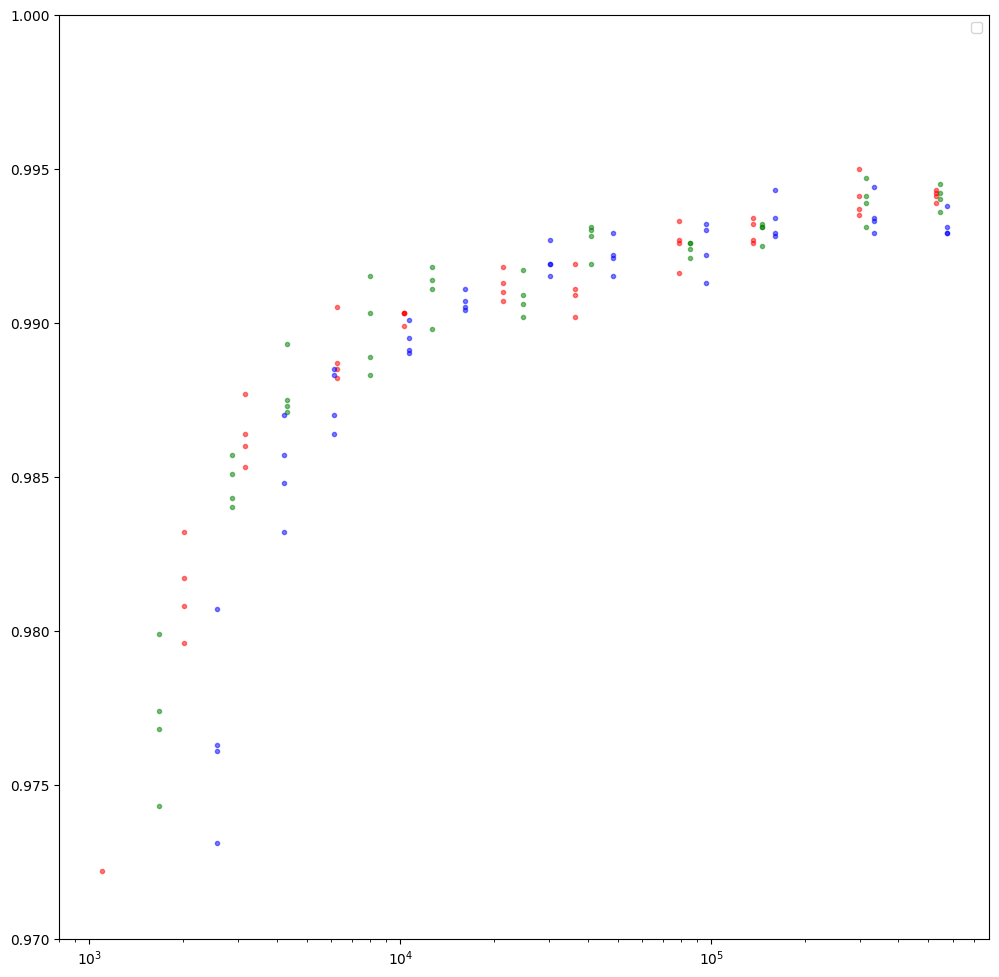

In [13]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 1)

for extra_pad, color in [(0, 'red'), (1, 'green'), (2, 'blue')]:
    ax.scatter([p[0] for p in results[extra_pad]], [p[1] for p in results[extra_pad]], c=color, alpha=0.5, marker=r'.')

ax.legend()
plt.show()